In [1]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import os

## Nuevo

In [5]:
def read_folder(path, prefix, save=True, save_name=None):
    dataframes = []
    # Iterate over all files in the folder
    for filename in os.listdir(path):
        # Check if the file starts with the desired prefix
        if filename.startswith(prefix) and filename.endswith('.csv'):
            # Construct the full file path
            file_path = os.path.join(folder_path, filename)
            # Read the CSV file into a dataframe
            df = pd.read_csv(file_path,sep=';')
            # Append the dataframe to the list
            dataframes.append(df)

    # Concatenate all dataframes in the list
    if dataframes:
        concatenated_df = pd.concat(dataframes, ignore_index=True)
        print("Concatenation successful!")
        concatenated_df = concatenated_df[['value','datetime']]
        concatenated_df['datetime'] = pd.to_datetime(concatenated_df['datetime'], utc=True)
        concatenated_df = concatenated_df.drop_duplicates(subset='datetime', keep='first')
        concatenated_df = concatenated_df.set_index('datetime',drop=True)
        if save:
            if save_name is None:
                save_name = prefix
            concatenated_df.to_csv(os.path.join(path,save_name+'.csv'))
    else:
        concatenated_df = pd.DataFrame()
        print("No matching files found.")
    return concatenated_df

folder_path = os.path.join(os.path.curdir,'data')
df_spv = read_folder(folder_path, 'export_GeneracionTRealSolarFotovoltaica_',save=True,save_name='generacion_solarpv')
df_st = read_folder(folder_path, 'export_GeneracionTRealSolarTermica_',save=True,save_name='generacion_solarthermal')
df_w = read_folder(folder_path, 'GeneracionMedidaEolica',save=True,save_name='generacion_wind')

Concatenation successful!
Concatenation successful!
Concatenation successful!


In [6]:
df_spv_pot = read_folder(folder_path,'potencia_instalada_solar_ph',save=False)
df_st_pot = read_folder(folder_path,'potencia_instalada_solar_th',save=False)
df_w_pot = read_folder(folder_path,'potencia_instalada_eolica',save=False)
df_w_pot

Concatenation successful!
Concatenation successful!
Concatenation successful!


,value
datetime,
2014-12-31 23:00:00+00:00,22930.612
2015-01-31 23:00:00+00:00,22930.612
2015-02-28 23:00:00+00:00,22930.612
2015-03-31 22:00:00+00:00,22930.712
2015-04-30 22:00:00+00:00,22932.512
...,...
2023-09-30 22:00:00+00:00,30648.979
2023-10-31 23:00:00+00:00,30743.379
2023-11-30 23:00:00+00:00,30748.379


In [7]:
df = df_spv.merge(df_st,how='outer',left_index=True,right_index=True).merge(df_w,how='outer',left_index=True,right_index=True)
df.columns = ['gen_spv','gen_st','gen_w']
df = df.merge(df_spv_pot,how='outer',left_index=True,right_index=True).merge(df_st_pot,how='outer',left_index=True,right_index=True).merge(df_w_pot,how='outer',left_index=True,right_index=True)
df.columns = ['gen_spv','gen_st','gen_w','pot_spv','pot_st','pot_w']
df['pot_spv'] = df['pot_spv'].ffill()
df['pot_st'] = df['pot_st'].ffill()
df['pot_w'] = df['pot_w'].ffill()
df = df.dropna()
df['fp_spv'] = df['gen_spv']/df['pot_spv']
df['fp_st'] = df['gen_st']/df['pot_st']
df['fp_w'] = df['gen_w']/df['pot_w']

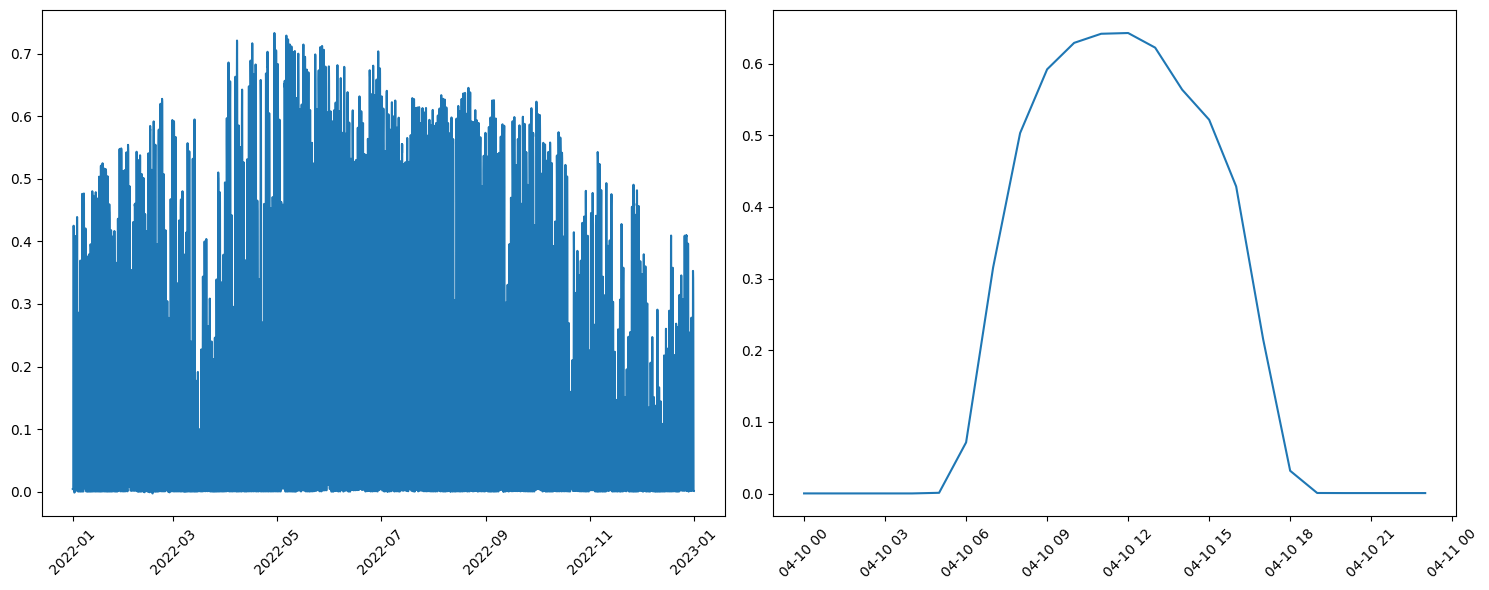

In [8]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
ax[0].plot(df[df.index.year==2022].index, df[df.index.year==2022]['fp_spv'])
ax[1].plot(df[(df.index.year==2022)&(df.index.dayofyear==100)].index, df[(df.index.year==2022)&(df.index.dayofyear==100)]['fp_spv'])

ax[0].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='x', rotation=45)
plt.tight_layout()

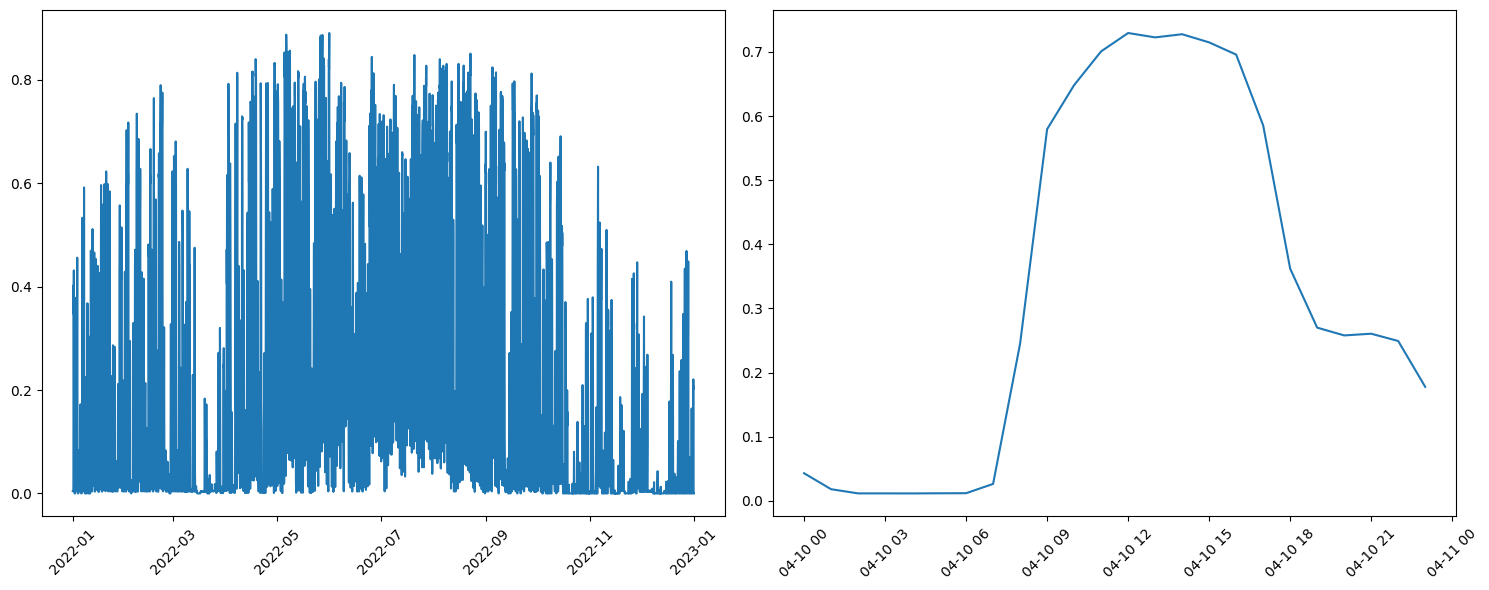

In [9]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
ax[0].plot(df[df.index.year==2022].index, df[df.index.year==2022]['fp_st'])
ax[1].plot(df[(df.index.year==2022)&(df.index.dayofyear==100)].index, df[(df.index.year==2022)&(df.index.dayofyear==100)]['fp_st'])

ax[0].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='x', rotation=45)
plt.tight_layout()

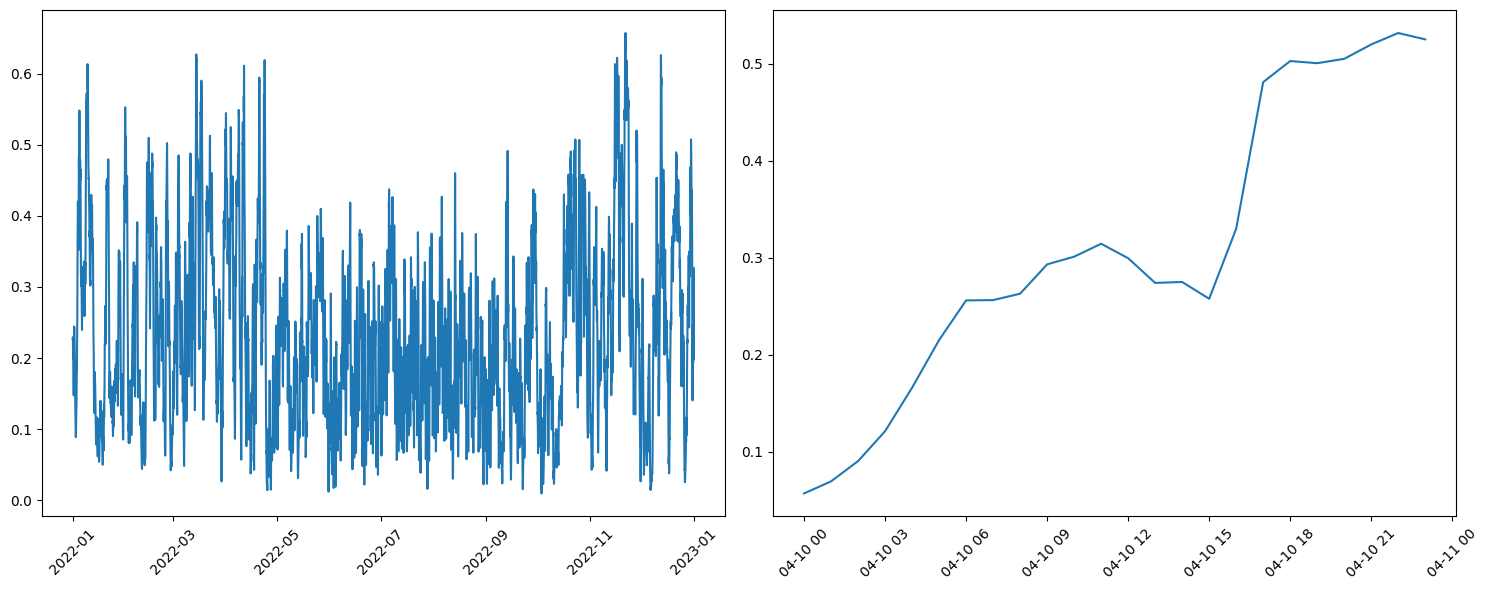

In [10]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
ax[0].plot(df[df.index.year==2022].index, df[df.index.year==2022]['fp_w'])
ax[1].plot(df[(df.index.year==2022)&(df.index.dayofyear==100)].index, df[(df.index.year==2022)&(df.index.dayofyear==100)]['fp_w'])

ax[0].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='x', rotation=45)
plt.tight_layout()

In [13]:
df_fp = df[['fp_spv','fp_st','fp_w']]
df_fp = df_fp.rename(columns={
    'fp_spv': 'solar_pv',
    'fp_st': 'solar_th',
    'fp_w': 'wind'
})
df_fp[df_fp<=0]=1e-3
df_fp.to_csv('./data/factor_capacidad.csv')

## Generacion

In [3]:
eolica = []
solar = []
print('Mix:')
for i in range(2011,2014):
    df = pd.read_csv(f"data/generacion_{i}.csv", index_col=0, parse_dates=True)
    df_e = df[['Eólica']].rename(columns={
        'Eólica':'value'
    })
    df_s = df[['Solar']].rename(columns={
        'Solar': 'value'
    })
    print(i,len(df_e),len(df_s))
    eolica.append(df_e)
    solar.append(df_s)
print("Eolica:")
for i in range(2014,2024):
    df = pd.read_csv(f'data/GeneracionMedidaEolica_{i}.csv', sep=';', index_col=5, parse_dates=True)
    df = df[['value']]
    print(i,len(df))
    eolica.append(df)

print("Solar:")
for i in range(2014,2024):
    df = pd.read_csv(f'data/GeneracionMedidaSolar_{i}.csv', sep=';', index_col=5, parse_dates=True)
    df = df[['value']]
    print(i,len(df))
    solar.append(df)

df_eolica = pd.concat(eolica)
df_solar = pd.concat(solar)

Mix:


2011 8760 8760
2012 8784 8784
2013 8760 8760
Eolica:
2014 8760
2015 8760
2016 8784
2017 8760
2018 8760
2019 8760
2020 8784
2021 8760
2022 8760
2023 8016
Solar:
2014 8760
2015 8760
2016 8784
2017 8760
2018 8760
2019 8760
2020 8784
2021 8760
2022 8760
2023 8016


In [4]:
df_solar[df_solar['value'].isna()]

,value
2011-03-27 02:00:00,NaN
2011-10-30 02:00:00,NaN
2012-03-25 02:00:00,NaN
2012-10-28 02:00:00,NaN
2013-03-31 02:00:00,NaN
2013-10-27 02:00:00,NaN


In [5]:
df_eolica[df_eolica['value'].isna()]

,value
2011-03-27 02:00:00,NaN
2011-10-30 02:00:00,NaN
2012-03-25 02:00:00,NaN
2012-10-28 02:00:00,NaN
2013-03-31 02:00:00,NaN
2013-10-27 02:00:00,NaN


In [16]:
df_total = df_solar.merge(df_eolica, left_index=True, right_index=True, how='outer')
df_total = df_total.rename(columns={
    'value_x': 'solar',
    'value_y': 'eolica'
})
df_total.head()

,solar,eolica
2011-01-01 00:00:00,0.0,788.833333
2011-01-01 01:00:00,0.0,665.916667
2011-01-01 02:00:00,0.0,580.083333
2011-01-01 03:00:00,0.0,492.500000
2011-01-01 04:00:00,0.0,514.333333


In [18]:
df_total.index = pd.to_datetime(df_total.index, format='ISO8601', utc=True)

In [10]:
duplicate_index = df_total.index.duplicated()

# Extract the duplicate index values
duplicate_values = df_total.index[duplicate_index]
duplicate_values
# df[(df.index>='2013-12-31 22:00:00')&(df.index<='2014-01-01 00:00:00')]
df_total.groupby()

DatetimeIndex(['2013-12-31 23:00:00+00:00'], dtype='datetime64[ns, UTC]', freq=None)

In [19]:
print(len(df_total))
df_total = df_total.reset_index()
df_total = df_total.groupby('index').agg('first')
print(len(df_total))

113208
113207


In [20]:
df_total = df_total.asfreq('h')

In [22]:
df_total.index

DatetimeIndex(['2011-01-01 00:00:00+00:00', '2011-01-01 01:00:00+00:00',
               '2011-01-01 02:00:00+00:00', '2011-01-01 03:00:00+00:00',
               '2011-01-01 04:00:00+00:00', '2011-01-01 05:00:00+00:00',
               '2011-01-01 06:00:00+00:00', '2011-01-01 07:00:00+00:00',
               '2011-01-01 08:00:00+00:00', '2011-01-01 09:00:00+00:00',
               ...
               '2023-11-30 13:00:00+00:00', '2023-11-30 14:00:00+00:00',
               '2023-11-30 15:00:00+00:00', '2023-11-30 16:00:00+00:00',
               '2023-11-30 17:00:00+00:00', '2023-11-30 18:00:00+00:00',
               '2023-11-30 19:00:00+00:00', '2023-11-30 20:00:00+00:00',
               '2023-11-30 21:00:00+00:00', '2023-11-30 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='index', length=113207, freq='H')

In [24]:
min_date = df_total.index.min()
max_date = df_total.index.max()
complete_index = pd.date_range(min_date, max_date, freq='H')
reference_df = pd.DataFrame(index=complete_index)

# Find missing values by comparing the reference DataFrame with your original DataFrame
missing_values = reference_df.index.difference(df_total.index)
missing_values

DatetimeIndex([], dtype='datetime64[ns, UTC]', freq='H')

In [25]:
df_total.to_csv('data/generacion_conjunto.csv')

## Potencia Instalada

In [47]:
df_pot_solar = pd.read_csv('data/potencia_instalada_solar.csv', sep=';', index_col=5, parse_dates=True)
df_pot_solar = df_pot_solar[['value']]

df_pot_eolica = pd.read_csv('data/potencia_instalada_eolica.csv', sep=';', index_col=5, parse_dates=True)
df_pot_eolica = df_pot_eolica[['value']]

df_pot = df_pot_solar.merge(df_pot_eolica, left_index=True, right_index=True, how='outer')
df_pot = df_pot.rename(columns={
    'value_x': 'solar',
    'value_y': 'eolica'
})
df_pot.index = pd.to_datetime(df_pot.index, format='ISO8601', utc=True)
df_pot = df_pot.loc[~df_pot.index.duplicated()]
df_pot.to_csv('data/potencia_instalada_conjunto.csv')
df_pot.head()

,solar,eolica
datetime,,
2014-12-31 23:00:00+00:00,4678.825,22930.612
2015-01-31 23:00:00+00:00,4678.895,22930.612
2015-02-28 23:00:00+00:00,4679.112,22930.612
2015-03-31 22:00:00+00:00,4679.219,22930.712
2015-04-30 22:00:00+00:00,4679.583,22932.512


## Factor Potencia

In [10]:
df_pot = pd.read_csv('data/potencia_instalada_conjunto.csv', index_col=0,parse_dates=True)
df_gen = pd.read_csv('data/generacion_conjunto.csv', index_col=0,parse_dates=True)
df_pot['year'] = (pd.to_datetime(df_pot.index) - timedelta(days=31)).year
df_pot['month'] = (pd.to_datetime(df_pot.index) - timedelta(days=31)).month
df_gen['year'] = pd.to_datetime(df_gen.index).year
df_gen['month'] = pd.to_datetime(df_gen.index).month
df_mix = df_gen.merge(df_pot, how='left', on=['year', 'month'], suffixes=['_gen', '_pot'])
df_mix.index = df_gen.index
df_mix_c = df_mix.dropna()
df_mix_c.loc[:,'solar_gen'] = df_mix_c.loc[:,'solar_gen']/ df_mix_c.loc[:,'solar_pot']
df_mix_c.loc[:,'eolica_gen'] = df_mix_c.loc[:,'eolica_gen'] / df_mix_c.loc[:,'eolica_pot']
df_mix_c = df_mix_c[['solar_gen', 'eolica_gen']]
df_mix_c = df_mix_c.rename(columns={
    'solar_gen': 'solar',
    'eolica_gen': 'eolica',
})
df_mix_c

,solar,eolica
index,,
2014-11-01 00:00:00+00:00,0.002629,0.150255
2014-11-01 01:00:00+00:00,0.002602,0.138126
2014-11-01 02:00:00+00:00,0.002614,0.116548
2014-11-01 03:00:00+00:00,0.002598,0.100003
2014-11-01 04:00:00+00:00,0.002586,0.085874
...,...,...
2023-11-30 18:00:00+00:00,0.000378,0.379457
2023-11-30 19:00:00+00:00,0.000363,0.379225
2023-11-30 20:00:00+00:00,0.000365,0.340313


In [12]:
df_mix_c.to_csv('data/factor_capacidad_conjunto.csv')

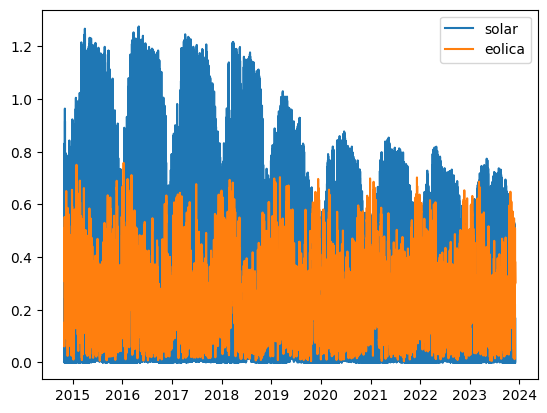

In [11]:
plt.plot(df_mix_c.index, df_mix_c['solar'])
plt.plot(df_mix_c.index, df_mix_c['eolica'])
plt.legend(['solar','eolica'])
plt.show()